# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast
from PIL import Image


from scipy.ndimage import gaussian_filter


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers



# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Preparing the Data 

Fixing Target Column 

In [3]:
# Convert the string representation of lists in 'target' column to actual lists
df_data['target'] = df_data['target'].apply(ast.literal_eval)

# Verify the conversion by displaying the first few rows of the 'target' column
df_data['target'].head()

0    [1, 0, 0, 0, 0, 0, 0, 0]
1    [1, 0, 0, 0, 0, 0, 0, 0]
2    [0, 1, 0, 0, 0, 0, 0, 0]
3    [0, 1, 0, 0, 0, 0, 0, 0]
4    [0, 1, 0, 0, 0, 0, 0, 0]
Name: target, dtype: object

Splitting Dataset into Training and Testing Sets

In [10]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

# Check the size of the training and test sets
train_size = df_train.shape[0]
test_size = df_test.shape[0]

(train_size, test_size)

(5113, 1279)

Splitting Training Data into Training and Validation Sets 

In [11]:
# Further split the df_train into training and validation sets
df_train_final, df_validation = train_test_split(df_train, test_size=0.2, random_state=42)

# Check the size of the new training and validation sets
train_final_size = df_train_final.shape[0]
validation_size = df_validation.shape[0]

(train_final_size, validation_size)

(4090, 1023)

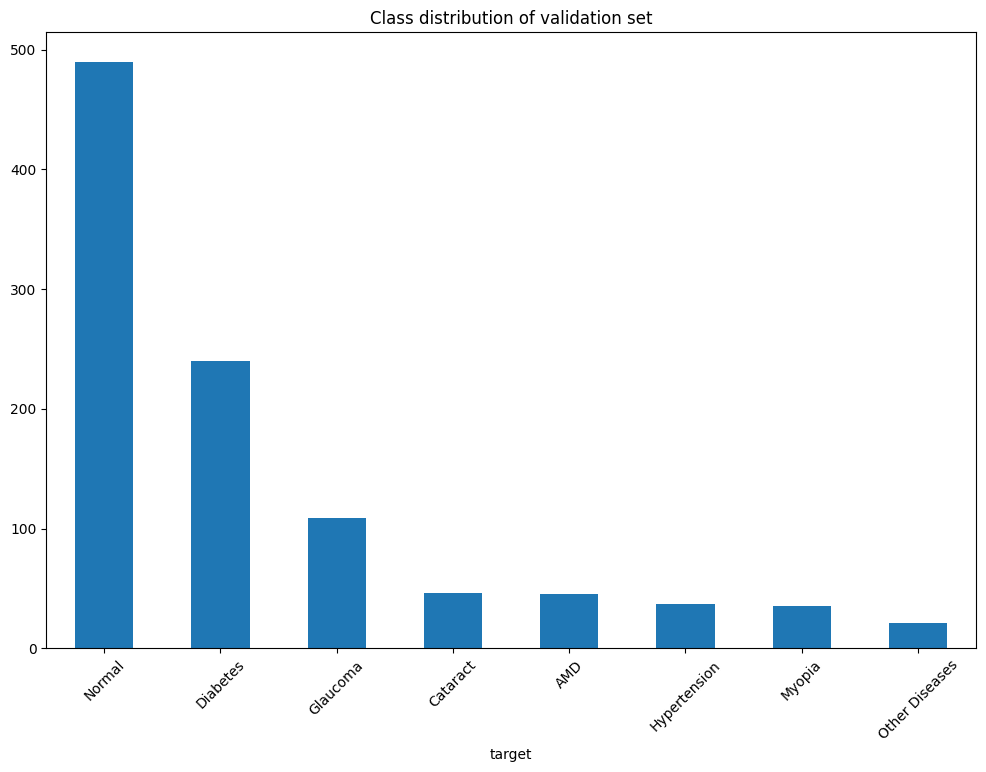

In [12]:
# class distribution of validation set
df_validation['target'].value_counts()

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# plot distribution of classes
plt.figure(figsize=(12, 8))
df_validation['target'].value_counts().plot(kind='bar')
plt.title('Class distribution of validation set')
plt.xticks(ticks=np.arange(8), labels=class_labels, rotation=45)
plt.show()




# Class Distribution
- Below is shown the distribution of images available for each different ocular condition. This distribution shows a significant imbalance, with "Normal" and "Diabetes" conditions being the most represented, while conditions like "Hypertension" and "Glaucoma" have far fewer images.

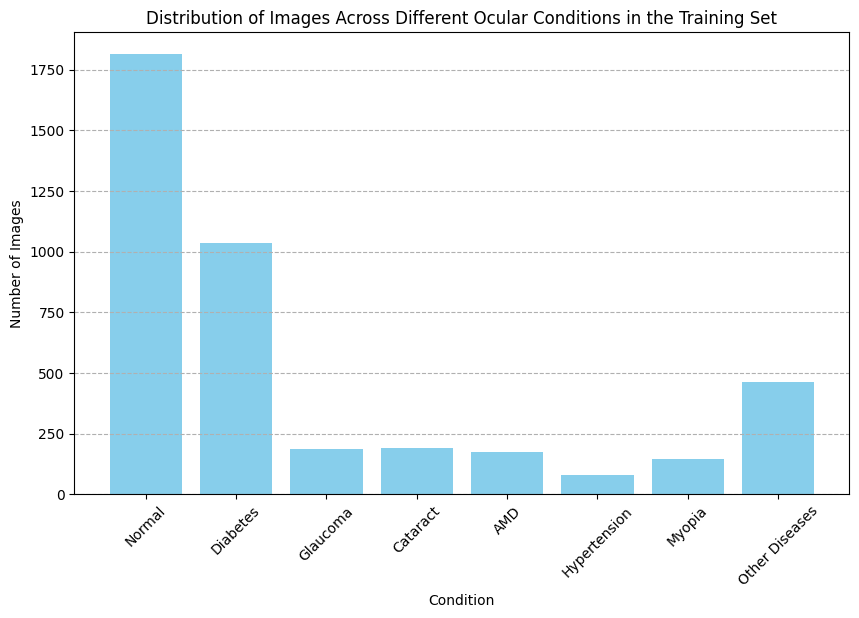

{'Normal': 1814,
 'Diabetes': 1035,
 'Glaucoma': 188,
 'Cataract': 190,
 'AMD': 174,
 'Hypertension': 79,
 'Myopia': 147,
 'Other Diseases': 463}

In [13]:
# Sum up all the target lists to get the class distribution
class_distribution = np.sum(df_train_final['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order as per your earlier description
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values(), color='skyblue')
plt.title('Distribution of Images Across Different Ocular Conditions in the Training Set')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

# Also, return the class distribution for detailed examination
class_distribution_dict

# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

Calculating Augmentations Required Per Class

In [ ]:
# Assuming 'class_distribution' is a dictionary with your class labels and counts
target_sample_count = max(class_distribution_dict.values())  # or set a custom target

augmentations_needed = {
    class_label: target_sample_count - count 
    for class_label, count in class_distribution_dict.items() if count < target_sample_count
}

# Calculate the number of augmentations needed per existing sample
augmentations_per_sample = {
    class_label: (augmentations_needed[class_label] // count) + 1  # Adding 1 for at least one augmentation
    for class_label, count in class_distribution_dict.items() if class_label in augmentations_needed
}

print(augmentations_per_sample)

In [ ]:

# Initialize the ImageDataGenerator with suitable augmentations for fundus images
augmentation = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.05,
    vertical_flip=True,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.2, 1.0],
    shear_range=0.05,
    fill_mode="constant",
)

save_directory = 'dataset/train_augmented_images/'
os.makedirs(save_directory, exist_ok=True)

augmentations_needed = {   # Doubling augementations needed for all classes
    0: 0,   # Normal
    1 : 1,  # Diabetes +1
    2 : 9, # Glaucoma
    3 : 9, # Cataract
    4 : 10, # AMD
    5 : 22, # Hypertension
    6 : 12, # Myopia
    7 : 3   # Other Diseases + 1
}

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    # Original image path
    img_path = os.path.join('dataset/preprocessed_images', row['filename'])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_rows = []
    
    # Determine the maximum number of augmentations needed
    targets = row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])
    
    # Save the original image to the new directory with a prefix to indicate it's original
    original_filename = f"original_{row['filename']}"
    original_save_path = os.path.join(save_directory, original_filename)
    img.save(original_save_path)  # Save the original image
    
    # Update the row for the original image and add to the augmented rows list
    original_row = row.copy()
    original_row['filename'] = original_filename
    augmented_rows.append(original_row)
    
    if max_augmentations_needed > 0:
        # Generate and save augmented images
        for i in range(max_augmentations_needed):
            # Manual save for more control over filenames
            augmented_img = next(augmentation.flow(x, batch_size=1))[0]  # Get one sample
            augmented_img = Image.fromarray(np.uint8(augmented_img))  # Convert to PIL Image to save
            unique_filename = f'aug_{i}_{row["filename"]}'
            save_path = os.path.join(save_directory, unique_filename)
            augmented_img.save(save_path)  # Save the augmented image
            
            # Update row for augmented image and add to the list
            augmented_row = row.copy()
            augmented_row['filename'] = unique_filename
            augmented_rows.append(augmented_row)
    
    return augmented_rows

# Usage with ThreadPoolExecutor, assuming df_train_final is your DataFrame to process
augmented_data = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = []
    for _, row in df_train_final.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            augmented_rows = future.result()
            augmented_data.extend(augmented_rows)  # Extend the list with both original and augmented rows
        except Exception as e:
            print(f"Error processing image: {e}")

# Assuming df_train_final and the necessary libraries are correctly defined
df_augmented = pd.DataFrame(augmented_data)
df_augmented.to_csv('dataset/augmented_train.csv', index=False)

In [ ]:
df_augmented.head()

Save Dfs

In [ ]:
df_augmented.to_csv('dataset\\csv\\df_train.csv', index=False)  
df_test.to_csv('dataset\\csv\\df_test.csv', index=False)
df_validation.to_csv('dataset\\csv\\df_validation.csv', index=False)


Distribution after Augmentation of Minority Classes

In [ ]:
class_distribution_augmented = np.sum(df_augmented['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order as per your earlier description
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# Map the distribution counts to the class labels
class_distribution_dict_augmented = dict(zip(class_labels, class_distribution_augmented))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_dict_augmented.keys(), class_distribution_dict_augmented.values(), color='skyblue')
plt.title('Distribution of Images Across Different Ocular Conditions in the Augmented Training Set')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Loading DFs

In [2]:
df_augmented = pd.read_csv('dataset\\csv\\augmented_train.csv')
df_test = pd.read_csv('dataset\\csv\\test.csv')
df_validation = pd.read_csv('dataset\\csv\\validation.csv')

# Creating Generators

In [3]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [4]:
# Initialize the ImageDataGenerator for the validation set
validation_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the validation generator
validation_generator = validation_augmentation.flow_from_dataframe(
    dataframe=df_validation,
    directory='dataset/preprocessed_images',
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1023 validated image filenames belonging to 8 classes.


In [5]:
# Create the training generator
train_augmentation = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_augmentation.flow_from_dataframe(
    dataframe=df_augmented,
    directory='dataset/train_augmented_images',
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 15158 validated image filenames belonging to 8 classes.


In [6]:
# For the test set, you can create a separate ImageDataGenerator instance without a validation split

# Create the test generator
test_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_augmentation.flow_from_dataframe(
    dataframe=df_test,
    directory='dataset/preprocessed_images',
    x_col='filename',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1279 validated image filenames belonging to 8 classes.


# Loading and Visualising the Training Data 

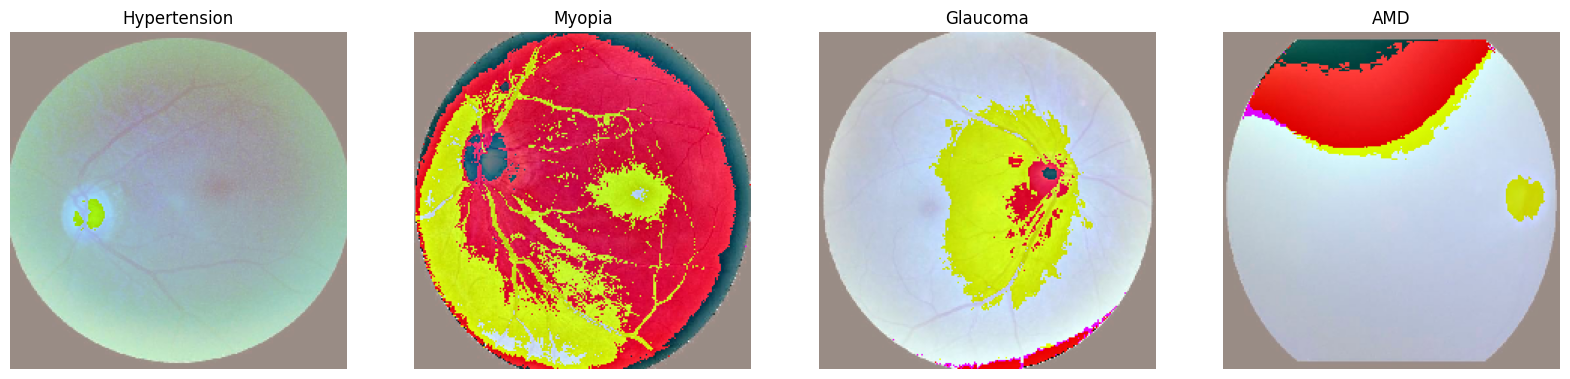

In [8]:
# Get the next batch of images from the training generator
images, labels = next(train_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

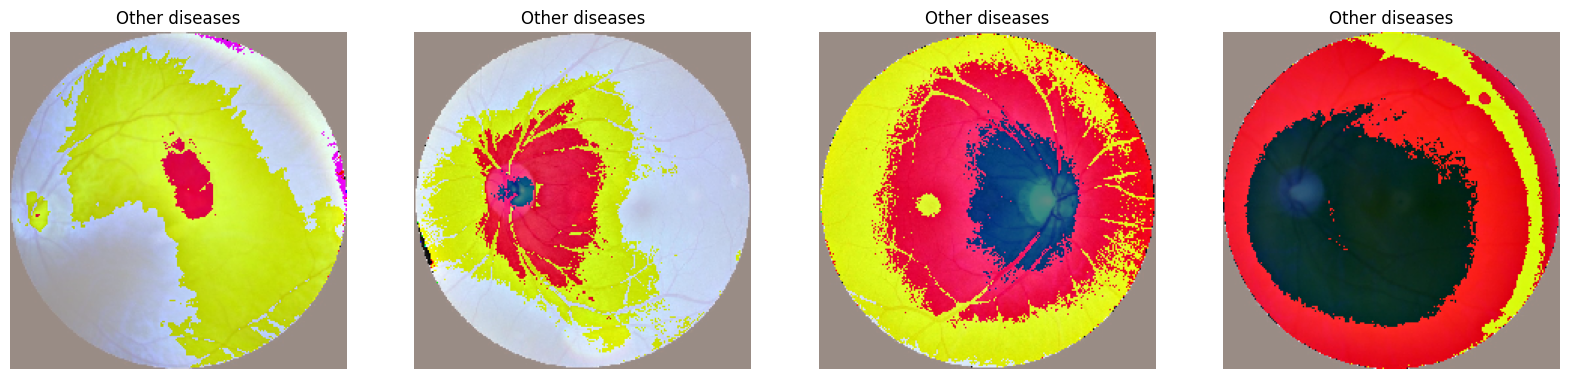

In [16]:
images, labels = next(validation_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

In [7]:
from sklearn.utils.class_weight import compute_class_weight


# The labels are already in the format compute_class_weight expects
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.labels),
    y=train_generator.labels
)

# Create a dictionary to map the class indices to their respective weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Display the class weights
print(class_weights_dict)

{0: 1.0230831533477323, 1: 0.9914965986394558, 2: 1.0427903137039076, 3: 0.9899425287356322, 4: 0.9972368421052632, 5: 1.007845744680851, 6: 0.9153381642512077, 7: 1.0445148842337375}


# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

In [26]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model_vgg16.h5', save_best_only=True, save_weights_only=False, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # increased from 5 to 10


callbacks = [early_stopping, checkpoint, reduce_lr]


In [27]:
# Load VGG16 as a base model, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to retain their pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for your classification task
x = layers.Flatten()(base_model.output) # Flatten the output of the base model
x = layers.Dense(256, activation='relu')(x) # from 1024 to 512
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x) # from 128 to 64

predictions = layers.Dense(8, activation='softmax')(x)  

# Define the model with the input from the base model and the output of your custom layers
vgg16_model = models.Model(inputs=base_model.input, outputs=predictions)  # Ensure `models.Model` is correctly used

# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  # Added 'optimizer'


In [28]:
vgg16_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
steps_per_epoch = train_generator.samples / 32

validation_steps = validation_generator.samples / 32

# Fit the model with callbacks
history = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    shuffle=True,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights_dict)

Epoch 1/50
474/473 [==============================] - ETA: 0s - loss: 2.1265 - accuracy: 0.3446
Epoch 1: val_loss improved from inf to 1.57741, saving model to best_model_vgg16.h5
473/473 [==============================] - 79s 165ms/step - loss: 2.1265 - accuracy: 0.3446 - val_loss: 1.5774 - val_accuracy: 0.4712 - lr: 1.0000e-04
Epoch 2/50
474/473 [==============================] - ETA: 0s - loss: 1.4551 - accuracy: 0.4534
Epoch 2: val_loss did not improve from 1.57741
473/473 [==============================] - 78s 165ms/step - loss: 1.4551 - accuracy: 0.4534 - val_loss: 1.5859 - val_accuracy: 0.4536 - lr: 1.0000e-04
Epoch 3/50
474/473 [==============================] - ETA: 0s - loss: 1.2703 - accuracy: 0.5166
Epoch 3: val_loss improved from 1.57741 to 1.35663, saving model to best_model_vgg16.h5
473/473 [==============================] - 79s 166ms/step - loss: 1.2703 - accuracy: 0.5166 - val_loss: 1.3566 - val_accuracy: 0.5191 - lr: 1.0000e-04
Epoch 4/50
474/473 [====================

# Evaluating Model 

Model Accuracy Graph Analysis

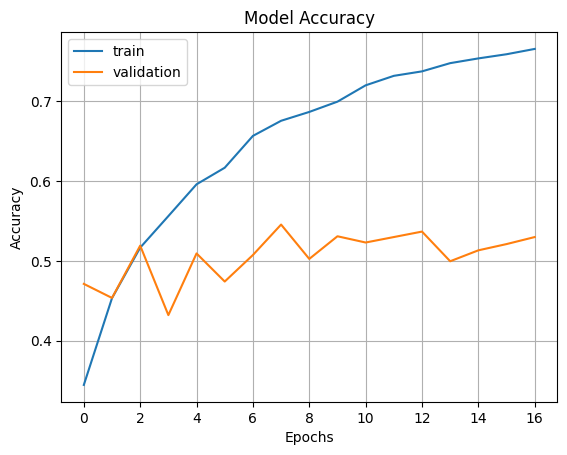

In [30]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

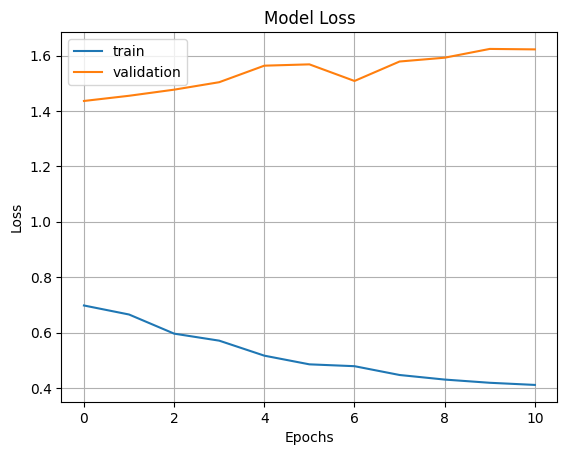

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [38]:
model_best = keras.models.load_model('best_model_vgg16.h5')

# Evaluate the model on the test set
test_loss, test_acc = model_best.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")

# Get the predictions for the test set

predictions = model_best.predict(test_generator, verbose=1)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

ResourceExhaustedError: Graph execution error:

Detected at node 'model_3/block1_conv2/Conv2D' defined at (most recent call last):
    File "c:\Users\duwak\.conda\envs\TF\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\duwak\.conda\envs\TF\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\duwak\.conda\envs\TF\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\duwak\.conda\envs\TF\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\duwak\.conda\envs\TF\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\duwak\.conda\envs\TF\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\duwak\AppData\Local\Temp\ipykernel_23108\1257644924.py", line 4, in <module>
      test_loss, test_acc = model_best.evaluate(test_generator, verbose=1)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'model_3/block1_conv2/Conv2D'
OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/block1_conv2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_92110]

In [21]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_generator.samples
test_batch_size = test_generator.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)

# Evaluate the model on the test dataset
vgg16_model.evaluate(test_generator, steps=steps)

# Re-generate predictions with the corrected steps
predictions = vgg16_model.predict(test_generator, steps=steps)

# Get the predicted classes again
predicted_classes = np.argmax(predictions, axis=1)


40/40 [==============================] - 6s 156ms/step


# Predictions Result Evaluation

In [22]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [23]:

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Get the true classes from the DataFrame
true_classes = test_generator.classes

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.31      0.03      0.05       136
      Diabetes       0.84      0.54      0.66        48
      Glaucoma       0.71      0.18      0.29        28
      Cataract       0.17      0.15      0.16        46
           AMD       0.80      0.60      0.69        58
  Hypertension       0.38      0.18      0.24        61
        Myopia       0.47      0.36      0.40       333
Other diseases       0.54      0.81      0.65       569

      accuracy                           0.52      1279
     macro avg       0.53      0.36      0.39      1279
  weighted avg       0.50      0.52      0.48      1279



Balanced Accuracy Score 

In [24]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.3566


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [25]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.7780


Confusion Matrix 

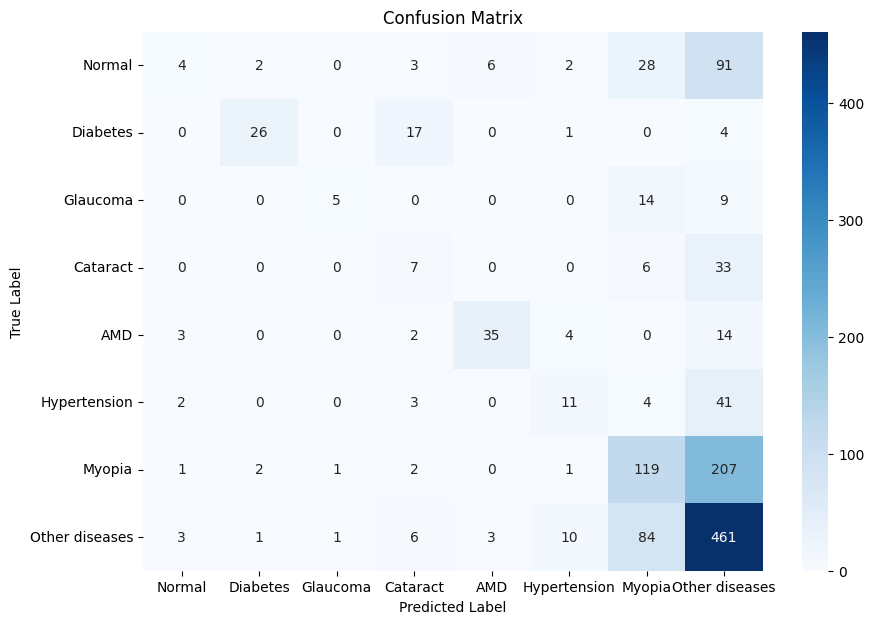

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

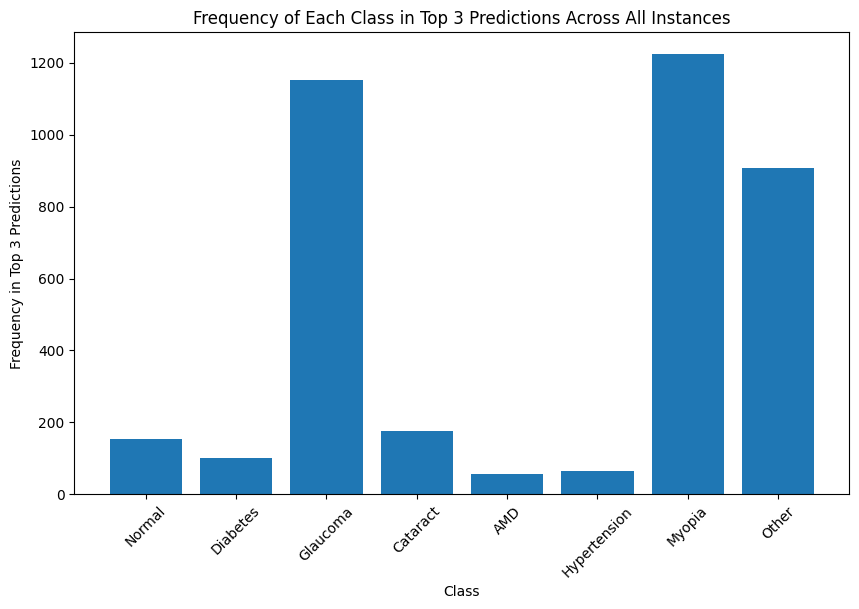

In [58]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model_v2.h5')